# **임대주택 단지 내 적정 주차수요 예측 대회**

모델을 골라봅시다.

In [169]:
PATH = r'C:\Users\Wyatt\wyatt37\data\parking'

In [170]:
import pandas as pd
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

import warnings
warnings.filterwarnings("ignore")

In [171]:
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

In [172]:
from pycaret.regression import *

In [173]:
age_gender = pd.read_csv(PATH + '\\new_age_gender_info.csv')
train = pd.read_csv(PATH + '\\new_train.csv')
test = pd.read_csv(PATH + '\\new_test.csv')
sub = pd.read_csv(PATH + '\\new_sample_submission.csv')

# PREPROCESSING

In [174]:
# 컬럼명이 너무 긴 지하철과 버스만 바꿔주겠습니다.
train.rename({'도보 10분거리 내 지하철역 수(환승노선 수 반영)': '지하철',
             '도보 10분거리 내 버스정류장 수': '버스'}, axis=1, inplace=True)
test.rename({'도보 10분거리 내 지하철역 수(환승노선 수 반영)': '지하철',
             '도보 10분거리 내 버스정류장 수': '버스'}, axis=1, inplace=True)

## FILLNA

### Subway

In [175]:
# train set에 지하철 정보가 없는 경남, 충남은 0으로 보간
train.loc[(train['지역'].isin(['경상남도', '충청남도'])) & (train['지하철'].isnull()), '지하철'] = 0

In [176]:
# LH청약센터에서 찾은 주소로 확인한 대전의 8개 단지는 지하철이 없음
# 0으로 채워줍시다.

(train.loc[(train['지역'] == '대전광역시') & (train['지하철'].isnull()) , '지하철']) = 0

In [177]:
# test set에 지하철 정보가 없는 충남은 0으로 보간
test.loc[(test['지역'].isin(['충청남도'])) & (test['지하철'].isnull()), '지하철'] = 0

In [178]:
# LH청약센터에서 찾은 주소로 확인한 대전의 2개 단지는 지하철이 없음
# 0으로 채워줍시다.

(test.loc[(test['지역'] == '대전광역시') & (test['지하철'].isnull()) & (test['임대건물구분'] != '상가'), '지하철']) = 0

### Bus

In [179]:
# 버스정류장 결측치는 train set에 1개 단지에 존재
# 해당 단지는 양산신도시LH아파트 5단지
# 지도를 확인한 결과 보수적으로 잡아도 7개 이상

train.loc[train['버스'].isnull(), '버스'] = 7

### Rent

In [180]:
# test set 에 임대보증금과 임대료가 결측치인 1개 단지 존재
# 해당 단지는 대전둔산1단지주공아파트
# 공고문에 의거, 임대보증금과 임대료 아래와 같이 보간

test.loc[(test['임대건물구분'] != '상가') & (test['임대보증금'].isnull()), '임대보증금'] = [5787000, 5787000, 11574000]
test.loc[(test['임대건물구분'] != '상가') & (test['임대료'].isnull()), '임대료'] = [79980, 79980, 159960]

### Qualification

In [181]:
# C2411 아파트의 자격유형은 전부 A로 되어 있음.
# 동일하게 A로 보간

test.loc[(test['단지코드'] == 'C2411') & (test['자격유형'].isnull()), '자격유형'] = 'A'

In [182]:
# C2253 아파트의 자격유형은 전부 C로 되어 있음.
# 동일하게 C로 보간

test.loc[(test['단지코드'] == 'C2253') & (test['자격유형'].isnull()), '자격유형'] = 'C'

## VALUE PREPROCCESSING

### 총세대수, 전용면적별세대수 미일치 데이터 보간

In [183]:
# 경북혁신도시천년나무3단지
test.loc[test['단지코드'] == 'C2497', '전용면적별세대수'] = [114, 60, 275, 39]
# 속초청초아파트
train.loc[train['단지코드'] == 'C1206', '총세대수'] = 478
# 충무공동혁신도시LH아파트5단지
train.loc[train['단지코드'] == 'C2405', '전용면적별세대수'] = [100, 100, 400]
# 경북혁신LH천년나무2단지
train.loc[train['단지코드'] == 'C1740', '전용면적별세대수'] = [305, 126, 184, 168]
# LH강남아이파크
train.loc[train['단지코드'] == 'C1024', '전용면적별세대수'] = [195, 60, 15, 154, 99, 48, 42, 53, 29, 23]
# 서울서초A4BL
train.loc[train['단지코드'] == 'C1344', '전용면적별세대수'] = [106, 96, 41, 39, 42, 100]
# 남양주별내A1-3블록
train.loc[train['단지코드'] == 'C1804', '전용면적별세대수'] = [76, 82, 279, 28]
train = train.append({'단지코드': 'C1804',
              '총세대수': 478,
              '임대건물구분': '아파트',
              '지역': '경기도',
              '공급유형': '공공임대(10년)',
              '전용면적': 75.78,
              '전용면적별세대수': 13,
              '공가수': 3.0,
              '자격유형': 'A',
              '임대보증금': 78957000,
              '임대료': 530130,
              '지하철': 0.0,
              '버스': 3.0,
              '단지내주차면수': 629.0,
              '등록차량수': 951.0}, ignore_index=True)
# 진천군 연미로 131 천년나무7단지
train.loc[train['단지코드'] == 'C1490', '전용면적별세대수'] = [105, 84, 472, 88]
# 나주빛가람LH3단지
train.loc[train['단지코드'] == 'C2620', '전용면적별세대수'] = [60, 227, 316, 160, 266]
# 대전대신2구역2단지
train = train.append({'단지코드': 'C2470', '총세대수': 636, '임대건물구분': '아파트', '지역': '대전광역시', '공급유형': '공공분양',
              '전용면적': 74.99, '전용면적별세대수': 72, '공가수': 1.0, '자격유형': 'A', '임대보증금': 225013300, '임대료': '-',
              '지하철': 1.0, '버스': 2.0, '단지내주차면수': 772.0,
              '등록차량수': 887.0}, ignore_index=True)
train = train.append({'단지코드': 'C2470', '총세대수': 636, '임대건물구분': '아파트', '지역': '대전광역시', '공급유형': '공공분양',
              '전용면적': 74.95, '전용면적별세대수': 66, '공가수': 1.0, '자격유형': 'A', '임대보증금': 226278000, '임대료': '-',
              '지하철': 1.0, '버스': 2.0, '단지내주차면수': 772.0,
              '등록차량수': 887.0}, ignore_index=True)
train = train.append({'단지코드': 'C2470', '총세대수': 636, '임대건물구분': '아파트', '지역': '대전광역시', '공급유형': '공공분양',
              '전용면적': 74.99, '전용면적별세대수': 92, '공가수': 1.0, '자격유형': 'A', '임대보증금': 230417000, '임대료': '-',
              '지하철': 1.0, '버스': 2.0, '단지내주차면수': 772.0,
              '등록차량수': 887.0}, ignore_index=True)
#광주첨단H-2BL,H-3BL
train.loc[train['단지코드'] == 'C1970', '총세대수'] = 200
# 평택고덕Ca1, Ca2
train.loc[train['단지코드'] == 'C1894', '총세대수'] = 296

### Units(총세대수)

- 총세대수가 틀린 게 아니라, 전용면적별세대수가 틀린 것이라고 판단했습니다.
- 총세대수가 여전히 오차가 조금 있지만, 상가분양이라는 주최측의 답변이 있었습니다.
- 실제로 큰 차이가 없습니다.

In [184]:
# 전용면적별세대수를 합쳐서 총 세대수를 다시 넣어주겠습니다.
temp = (train
        .groupby(['단지코드'])['전용면적별세대수'].sum()
        .reset_index()
        .rename({'전용면적별세대수': '전용면적별세대수합'}, axis=1))

train = pd.merge(train, temp, on='단지코드')

In [185]:
# 전용면적별세대수를 합쳐서 총 세대수를 다시 넣어주겠습니다.
temp = (test
        .groupby(['단지코드'])['전용면적별세대수'].sum()
        .reset_index()
        .rename({'전용면적별세대수': '전용면적별세대수합'}, axis=1))

test = pd.merge(test, temp, on='단지코드')

### NewUnits

- 문제가 여럿 있습니다.
1. 총세대수가 면적별세대수의 총합보다 적은 단지가 있다. -> 레코드를 보간해준 경우 -> 큰쪽이 맞다.
2. 총세대수가 면적별세대수의 총합보다 큰 단지가 있다. -> 분양상가가 누락된 경우 -> 이 경우도 큰쪽이 맞다.
3. 같은 경우 -> 문제 없다.

In [186]:
train.loc[train['총세대수'] >= train['전용면적별세대수합'], '조정총세대수'] = train.loc[train['총세대수'] >= train['전용면적별세대수합']]['총세대수']
train.loc[train['총세대수'] < train['전용면적별세대수합'], '조정총세대수'] = train.loc[train['총세대수'] < train['전용면적별세대수합']]['전용면적별세대수합']

In [187]:
test.loc[test['총세대수'] >= test['전용면적별세대수합'], '조정총세대수'] = test.loc[test['총세대수'] >= test['전용면적별세대수합']]['총세대수']
test.loc[test['총세대수'] < test['전용면적별세대수합'], '조정총세대수'] = test.loc[test['총세대수'] < test['전용면적별세대수합']]['전용면적별세대수합']

### StdDeposit(환산보증금)

In [188]:
train.loc[train['임대보증금'] == '-', '임대보증금'] = 0
test.loc[test['임대보증금'] == '-', '임대보증금'] = 0

train.loc[train['임대료'] == '-', '임대료'] = 0
test.loc[test['임대료'] == '-', '임대료'] = 0

In [189]:
# nan 값 때문에 object로 되어 있습니다. 일단 0으로 채워 줍니다.
train['임대보증금'] = train['임대보증금'].fillna(0)
test['임대보증금'] = test['임대보증금'].fillna(0)

train['임대료'] = train['임대료'].fillna(0)
test['임대료'] = test['임대료'].fillna(0)

In [190]:
# 계산을 위해서 int로 바꿔줍니다.
train['임대보증금'] = train['임대보증금'].astype(int)
test['임대보증금'] = test['임대보증금'].astype(int)

train['임대료'] = train['임대료'].astype(int)
test['임대료'] = test['임대료'].astype(int)

기존의 환산보증금 공식으로 가면, 전세금과 환산보증금 차이가 너무 심합니다.<br>
전세와 월세가 동시에 있는 단지가 1개 있습니다. 이 단지를 기준으로 환산보증금을 재계산 합니다.

In [191]:
(187694000/51.32) - ((45456000 + (356420 * 354))/46.96)

2542.080887400545

In [192]:
# 환산보증금 컬럼을 만들어줍니다.
train['환산보증금'] = train['임대보증금'] + train['임대료'] * 354
test['환산보증금'] = test['임대보증금'] + test['임대료'] * 354

In [193]:
# 제곱미터당 환산보증금을 만들어줍니다.
train['면적당환산보증금'] = (train['환산보증금'] / train['전용면적']).round()
test['면적당환산보증금'] = (test['환산보증금'] / test['전용면적']).round()

- 임대료가 없는 아파트를 찾아서 값을 넣어주겠습니다.

In [194]:
# C1350은 같은 단지에 다른 임대보증금, 임대료가 있습니다.
train.loc[(train['단지코드'] == 'C1350') & (train['임대보증금'] == 0), '면적당환산보증금'] = train.loc[(train['단지코드'] == 'C1350') & (train['임대보증금'] != 0)]['면적당환산보증금'].mean()

In [195]:
# C1786은 같은 단지에 다른 임대보증금, 임대료가 있습니다.
train.loc[(train['단지코드'] == 'C1786') & (train['임대보증금'] == 0), '면적당환산보증금'] = train.loc[(train['단지코드'] == 'C1786') & (train['임대보증금'] != 0)]['면적당환산보증금'].mean()

In [196]:
# C2186은 같은 단지에 다른 임대보증금, 임대료가 있습니다.
train.loc[(train['단지코드'] == 'C2186') & (train['임대보증금'] == 0), '면적당환산보증금'] = train.loc[(train['단지코드'] == 'C2186') & (train['임대보증금'] != 0)]['면적당환산보증금'].mean()

In [197]:
# C1326은 비슷한 유형의 단지를 찾아 평균값으로 넣겠습니다.
train.loc[train['단지코드'] == 'C1326', '면적당환산보증금'] = train.loc[(train['지역'] == '부산광역시')
                                                                  & (train['지하철'] == 0)
                                                                  & (train['임대건물구분'] != '상가')
                                                                  & (train['공급유형'] == '국민임대')
                                                                  & (train['단지코드'] != 'C1326')]['면적당환산보증금'].mean()

In [198]:
# C1267은 같은 단지에 다른 임대보증금, 임대료가 있습니다.
test.loc[(test['단지코드'] == 'C1267') & (test['임대보증금'] == 0), '면적당환산보증금'] = test.loc[(test['단지코드'] == 'C1267') & (test['임대보증금'] != 0)]['면적당환산보증금'].mean()

In [199]:
# C2152은 비슷한 유형의 단지를 찾아 평균값으로 넣겠습니다.
test.loc[test['단지코드'] == 'C2152', '면적당환산보증금'] = test.loc[(test['지역'] == '강원도')
                                                              & (test['임대건물구분'] != '상가')
                                                              & (test['공급유형'] == '영구임대')
                                                              & (test['단지코드'] != 'C2152')]['면적당환산보증금'].mean()

### RecruitType(공급유형)

In [200]:
# # 공공분양이 있는 1개 단지는 동일 단지의 공공임대로 맞춰주겠습니다.
# train.loc[train['공급유형'] == '공공분양', '공급유형'] = '공공임대'

In [201]:
# # 장기전세가 있는 1개 단지는 유사 유형의 행복주택으로 맞춰주겠습니다.
# train.loc[train['공급유형'] == '장기전세', '공급유형'] = '행복주택'

In [202]:
# # 공공임대(5년, 10년, 50년)는 햇수는 다르지만, 하나로 묶어주는 겠습니다.
# train.loc[train['공급유형'].str.contains('공공임대'), '공급유형'] = '공공임대'
# test.loc[test['공급유형'].str.contains('공공임대'), '공급유형'] = '공공임대'

### Qualification

In [203]:
# 상가가 아닌데 D형이 있습니다.

# 같은 단지에 A형이 있으므로 A로 넣어주겠습니다.
train.loc[(train['임대건물구분'] != '상가') & (train['자격유형'] == 'D'), '자격유형'] = 'A'

# 같은 단지에 C형이 있으므로 C로 넣어주겠습니다.
test.loc[(test['임대건물구분'] != '상가') & (test['자격유형'] == 'D'), '자격유형'] = 'C'

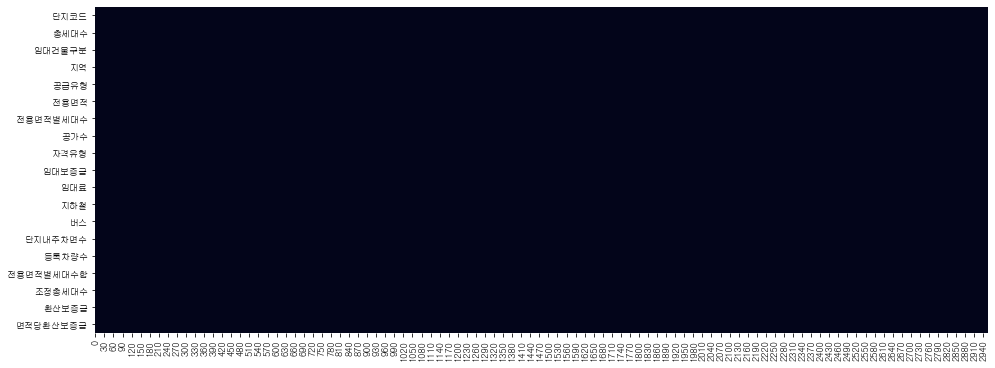

In [204]:
plt.figure(figsize=(16, 6))
sns.heatmap(train.isnull().T, cbar=False)
plt.show()

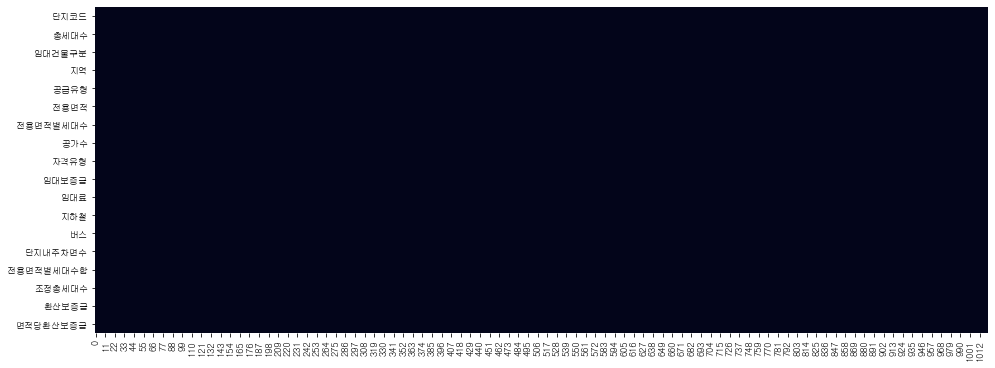

In [205]:
plt.figure(figsize=(16, 6))
sns.heatmap(test.isnull().T, cbar=False)
plt.show()

## FEATURE CREATION

### Residence(실거주)

In [206]:
# 공가수를 빼준 실거주 수를 만들어줍니다.
train['실거주세대수'] = train['조정총세대수'] - train['공가수']
test['실거주세대수'] = test['조정총세대수'] - test['공가수']

### UnitType(전용면적구분)

In [207]:
# 80 ~ 은 대형
# 40 ~ 80 은 중형
# ~ 40 은 소형

train.loc[train['전용면적'] < 40, '전용면적구분'] = '소형'
train.loc[train['전용면적'] >= 40, '전용면적구분'] = '중형'
train.loc[train['전용면적'] >= 80, '전용면적구분'] = '대형'

test.loc[test['전용면적'] < 40, '전용면적구분'] = '소형'
test.loc[test['전용면적'] >= 40, '전용면적구분'] = '중형'
test.loc[test['전용면적'] >= 80, '전용면적구분'] = '대형'

### Rooms(방의 개수)

In [208]:
train.loc[train['전용면적'] < 35, '방개수'] = '원룸'
train.loc[train['전용면적'] >= 35, '방개수'] = '투룸'
train.loc[train['전용면적'] >= 45, '방개수'] = '쓰리룸'
train.loc[train['전용면적'] >= 56, '방개수'] = '포룸'
train.loc[train['전용면적'] >= 77, '방개수'] = '오룸'

In [209]:
test.loc[test['전용면적'] < 35, '방개수'] = '원룸'
test.loc[test['전용면적'] >= 35, '방개수'] = '투룸'
test.loc[test['전용면적'] >= 45, '방개수'] = '쓰리룸'
test.loc[test['전용면적'] >= 56, '방개수'] = '포룸'
test.loc[test['전용면적'] >= 77, '방개수'] = '오룸'

### AllNewStdDep(면적당환산보증금가중평균)

가중평균을 내주기로 했습니다.

In [210]:
unique_code = list(train['단지코드'].unique())

for code in unique_code:
    train.loc[train['단지코드'] == code, '면적당환산보증금가중평균'] = np.average(train.loc[train['단지코드'] == code, '면적당환산보증금'],
                                                                  weights=train.loc[train['단지코드'] == code, '전용면적별세대수'])

In [211]:
unique_code = list(test['단지코드'].unique())

for code in unique_code:
    test.loc[test['단지코드'] == code, '면적당환산보증금가중평균'] = np.average(test.loc[test['단지코드'] == code, '면적당환산보증금'],
                                                                weights=test.loc[test['단지코드'] == code, '전용면적별세대수'])

### SumStdDep(시그마 면적당환산보증금 X 세대수)

면적당환산보증금을 평균으로 집어넣으니 정보손실이 생기는 것 같습니다. 세대수와 곱해서 총합을 넣어버리겠습니다.

In [212]:
train['면적당환산보증금세대수합계'] = train['전용면적별세대수'] * train['면적당환산보증금']
test['면적당환산보증금세대수합계'] = test['전용면적별세대수'] * test['면적당환산보증금']

### Shop(상가세대수)

- 총세대수와 전용면적별세대수합계가 미일치하는 부분이 상가세대수입니다.

In [213]:
temp1 = (train.groupby(['단지코드'])['조정총세대수'].max() - train.groupby(['단지코드'])['전용면적별세대수'].sum()).to_frame().rename({0: '분양상가수'}, axis=1)
temp2 = train.loc[train['임대건물구분'] == '상가'].groupby(['단지코드'])['전용면적별세대수'].sum().to_frame().rename({'전용면적별세대수':'임대상가수'}, axis=1)
temp3 = pd.merge(temp1, temp2, how='outer', on='단지코드').fillna(0)
temp4 = (temp3['분양상가수'] + temp3['임대상가수']).to_frame().rename({0: '상가세대수'}, axis=1)
train = pd.merge(train.loc[train['임대건물구분'] == '아파트'], temp4, how='outer', on='단지코드').fillna(0)

In [214]:
temp1 = (test.groupby(['단지코드'])['조정총세대수'].max() - test.groupby(['단지코드'])['전용면적별세대수'].sum()).to_frame().rename({0: '분양상가수'}, axis=1)
temp2 = test.loc[test['임대건물구분'] == '상가'].groupby(['단지코드'])['전용면적별세대수'].sum().to_frame().rename({'전용면적별세대수':'임대상가수'}, axis=1)
temp3 = pd.merge(temp1, temp2, how='outer', on='단지코드').fillna(0)
temp4 = (temp3['분양상가수'] + temp3['임대상가수']).to_frame().rename({0: '상가세대수'}, axis=1)
test = pd.merge(test.loc[test['임대건물구분'] == '아파트'], temp4, how='outer', on='단지코드').fillna(0)

In [215]:
# 처리가 끝난 상가 레코드는 드랍합니다.
train = train.loc[train['임대건물구분'] == '아파트', ~train.columns.isin(['임대건물구분'])]
test = test.loc[test['임대건물구분'] == '아파트', ~test.columns.isin(['임대건물구분'])]

In [216]:
# shop_temp = ((train.loc[train['임대건물구분'] == '상가']
#               .groupby(['단지코드'])['지역'].count())
#              .reset_index()
#              .rename({'지역': '상가세대수'}, axis=1))
# train = pd.merge(train.loc[train['임대건물구분'] == '아파트'], shop_temp, how='outer', on='단지코드').fillna(0)

In [217]:
# shop_temp = ((test.loc[test['임대건물구분'] == '상가']
#               .groupby(['단지코드'])['지역'].count())
#              .reset_index()
#              .rename({'지역': '상가세대수'}, axis=1))
# test = pd.merge(test.loc[test['임대건물구분'] == '아파트'], shop_temp, how='outer', on='단지코드').fillna(0)

### AgeGender

AgeGender에 대해서 다음과 같은 변수를 만들어줘야겠습니다.

- 성인비중(20대~60대)
- 미성년자비중(~ 10대)
- 성인남성비중(20대~60대)
- 성인여성비중(20대~60대)
- 노인비중(70대~)

In [218]:
ag = age_gender.set_index('지역')

In [219]:
# 성인(20대~60대)비중합
ag.loc[:, '청년비중'] = ag.loc[:, (ag.columns.str.contains('20대')) | (ag.columns.str.contains('30대')) | (ag.columns.str.contains('40대')) | (ag.columns.str.contains('50대')) | (ag.columns.str.contains('60대'))].sum(axis=1)
# 미성년자(10대이하)비중
ag.loc[:, '미성년자비중'] = ag.loc[:, (ag.columns.str.contains('10대'))].sum(axis=1)
# 노인비중(70대~)비중합
ag.loc[:, '노년비중'] = ag.loc[:, (ag.columns.str.contains('70대')) | (ag.columns.str.contains('80대')) | (ag.columns.str.contains('90대')) | (ag.columns.str.contains('100대'))].sum(axis=1)
# 성인여성비중
ag.loc[:, '청년여성비중'] = ag.loc[:, ['20대(여자)', '30대(여자)', '40대(여자)', '50대(여자)', '60대(여자)']].sum(axis=1)
# 성인남성비중
ag.loc[:, '청년남성비중'] = ag.loc[:, ['20대(남자)', '30대(남자)', '40대(남자)', '50대(남자)', '60대(남자)']].sum(axis=1)

In [220]:
train = pd.merge(train, ag.reset_index(), how='left', on='지역')
test = pd.merge(test, ag.reset_index(), how='left', on='지역')

In [221]:
train.shape, test.shape

((2394, 51), (845, 50))

## ENCODING

In [222]:
# 실거주세대 대비 차량수의 지역 평균으로 오름차순 정렬
# Order를 주었습니다.
region_dict = {'서울특별시': 0,
               '경기도':1,
               '세종특별자치시':2,
               '경상북도':3,
               '대구광역시':4,
               '광주광역시':5,
               '충청북도':6,
               '전라남도':7,
               '전라북도':8,
               '강원도':9,
               '경상남도':10,
               '울산광역시':11,
               '제주특별자치도':12,
               '대전광역시':13,
               '충청남도':14,
               '부산광역시':15}

train['지역'] = train['지역'].map(region_dict)
test['지역'] = test['지역'].map(region_dict)

In [223]:
# 전용면적구분 unstack
temp = train.groupby(['단지코드', '전용면적구분'])['전용면적별세대수'].sum().unstack().fillna(0)
train = pd.merge(train.loc[:, ~train.columns.isin(['전용면적구분'])], temp, on='단지코드')
temp = test.groupby(['단지코드', '전용면적구분'])['전용면적별세대수'].sum().unstack().fillna(0)
test = pd.merge(test.loc[:, ~test.columns.isin(['전용면적구분'])], temp, on='단지코드')

In [224]:
# 공급유형 unstack
temp = train.groupby(['단지코드', '공급유형'])['전용면적별세대수'].sum().unstack().fillna(0)
train = pd.merge(train.loc[:, ~train.columns.isin(['공급유형'])], temp, on='단지코드')
temp = test.groupby(['단지코드', '공급유형'])['전용면적별세대수'].sum().unstack().fillna(0)
test = pd.merge(test.loc[:, ~test.columns.isin(['공급유형'])], temp, on='단지코드')

In [225]:
# 자격유형 unstack
temp = train.groupby(['단지코드', '자격유형'])['전용면적별세대수'].sum().unstack().fillna(0)
train = pd.merge(train.loc[:, ~train.columns.isin(['자격유형'])], temp, on='단지코드')
temp = test.groupby(['단지코드', '자격유형'])['전용면적별세대수'].sum().unstack().fillna(0)
test = pd.merge(test.loc[:, ~test.columns.isin(['자격유형'])], temp, on='단지코드')

In [226]:
# 방개수 unstack
temp = train.groupby(['단지코드', '방개수'])['전용면적별세대수'].sum().unstack().fillna(0)
train = pd.merge(train.loc[:, ~train.columns.isin(['방개수'])], temp, on='단지코드')
temp = test.groupby(['단지코드', '방개수'])['전용면적별세대수'].sum().unstack().fillna(0)
test = pd.merge(test.loc[:, ~test.columns.isin(['방개수'])], temp, on='단지코드')

In [227]:
# 면적당환산보증금 단지별 평균으로 산출
temp = train.groupby(['단지코드'])['면적당환산보증금'].mean().reset_index()
train = pd.merge(train.loc[:, ~train.columns.isin(['면적당환산보증금'])], temp, on='단지코드')
temp = test.groupby(['단지코드'])['면적당환산보증금'].mean().reset_index()
test = pd.merge(test.loc[:, ~test.columns.isin(['면적당환산보증금'])], temp, on='단지코드')

In [228]:
# 면적당환산보증금가중평균 단지별로 산출
temp = train.groupby(['단지코드'])['면적당환산보증금가중평균'].max().reset_index()
train = pd.merge(train.loc[:, ~train.columns.isin(['면적당환산보증금가중평균'])], temp, on='단지코드')
temp = test.groupby(['단지코드'])['면적당환산보증금가중평균'].max().reset_index()
test = pd.merge(test.loc[:, ~test.columns.isin(['면적당환산보증금가중평균'])], temp, on='단지코드')

In [229]:
# 면적당환산보증금세대수 합계로 산출
temp = train.groupby(['단지코드'])['면적당환산보증금세대수합계'].sum().reset_index()
train = pd.merge(train.loc[:, ~train.columns.isin(['면적당환산보증금세대수합계'])], temp, on='단지코드')
temp = test.groupby(['단지코드'])['면적당환산보증금세대수합계'].sum().reset_index()
test = pd.merge(test.loc[:, ~test.columns.isin(['면적당환산보증금세대수합계'])], temp, on='단지코드')

In [230]:
# 전처리가 끝나서 필요없는 변수 삭제
train.drop(['총세대수', '전용면적', '임대보증금', '임대료', '환산보증금', '전용면적별세대수'], axis=1, inplace=True)
test.drop(['총세대수', '전용면적', '임대보증금', '임대료', '환산보증금', '전용면적별세대수'], axis=1, inplace=True)

# 다중공선성을 띄고 있는 변수 삭제
train.drop(['전용면적별세대수합'], axis=1, inplace=True)
test.drop(['전용면적별세대수합'], axis=1, inplace=True)

In [231]:
# 단지고유의 레코드만 남겨줍니다.
train = train.drop_duplicates().reset_index(drop=True)
test = test.drop_duplicates().reset_index(drop=True)

In [232]:
train.shape, test.shape

((423, 71), (150, 64))

In [233]:
ordered_cols = ['등록차량수', '단지코드', '지역', '공가수', '지하철', '버스', '단지내주차면수',
                '조정총세대수', '실거주세대수', '상가세대수',
                '소형', '중형', '오룸', '포룸', '쓰리룸', '투룸', '원룸',
                '공공임대(10년)', '공공임대(50년)', '공공임대(분납)', '국민임대', '영구임대', '행복주택',
                'A', 'C', 'E', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
                '면적당환산보증금가중평균', '면적당환산보증금세대수합계',
                '10대미만(여자)', '10대미만(남자)', '10대(여자)', '10대(남자)',
                '20대(여자)', '20대(남자)', '30대(여자)', '30대(남자)', '40대(여자)', '40대(남자)',
                '50대(여자)', '50대(남자)', '60대(여자)', '60대(남자)', '70대(여자)', '70대(남자)',
                '80대(여자)', '80대(남자)', '90대(여자)', '90대(남자)', '100대(여자)', '100대(남자)',
                '청년비중', '미성년자비중', '노년비중', '청년여성비중', '청년남성비중']

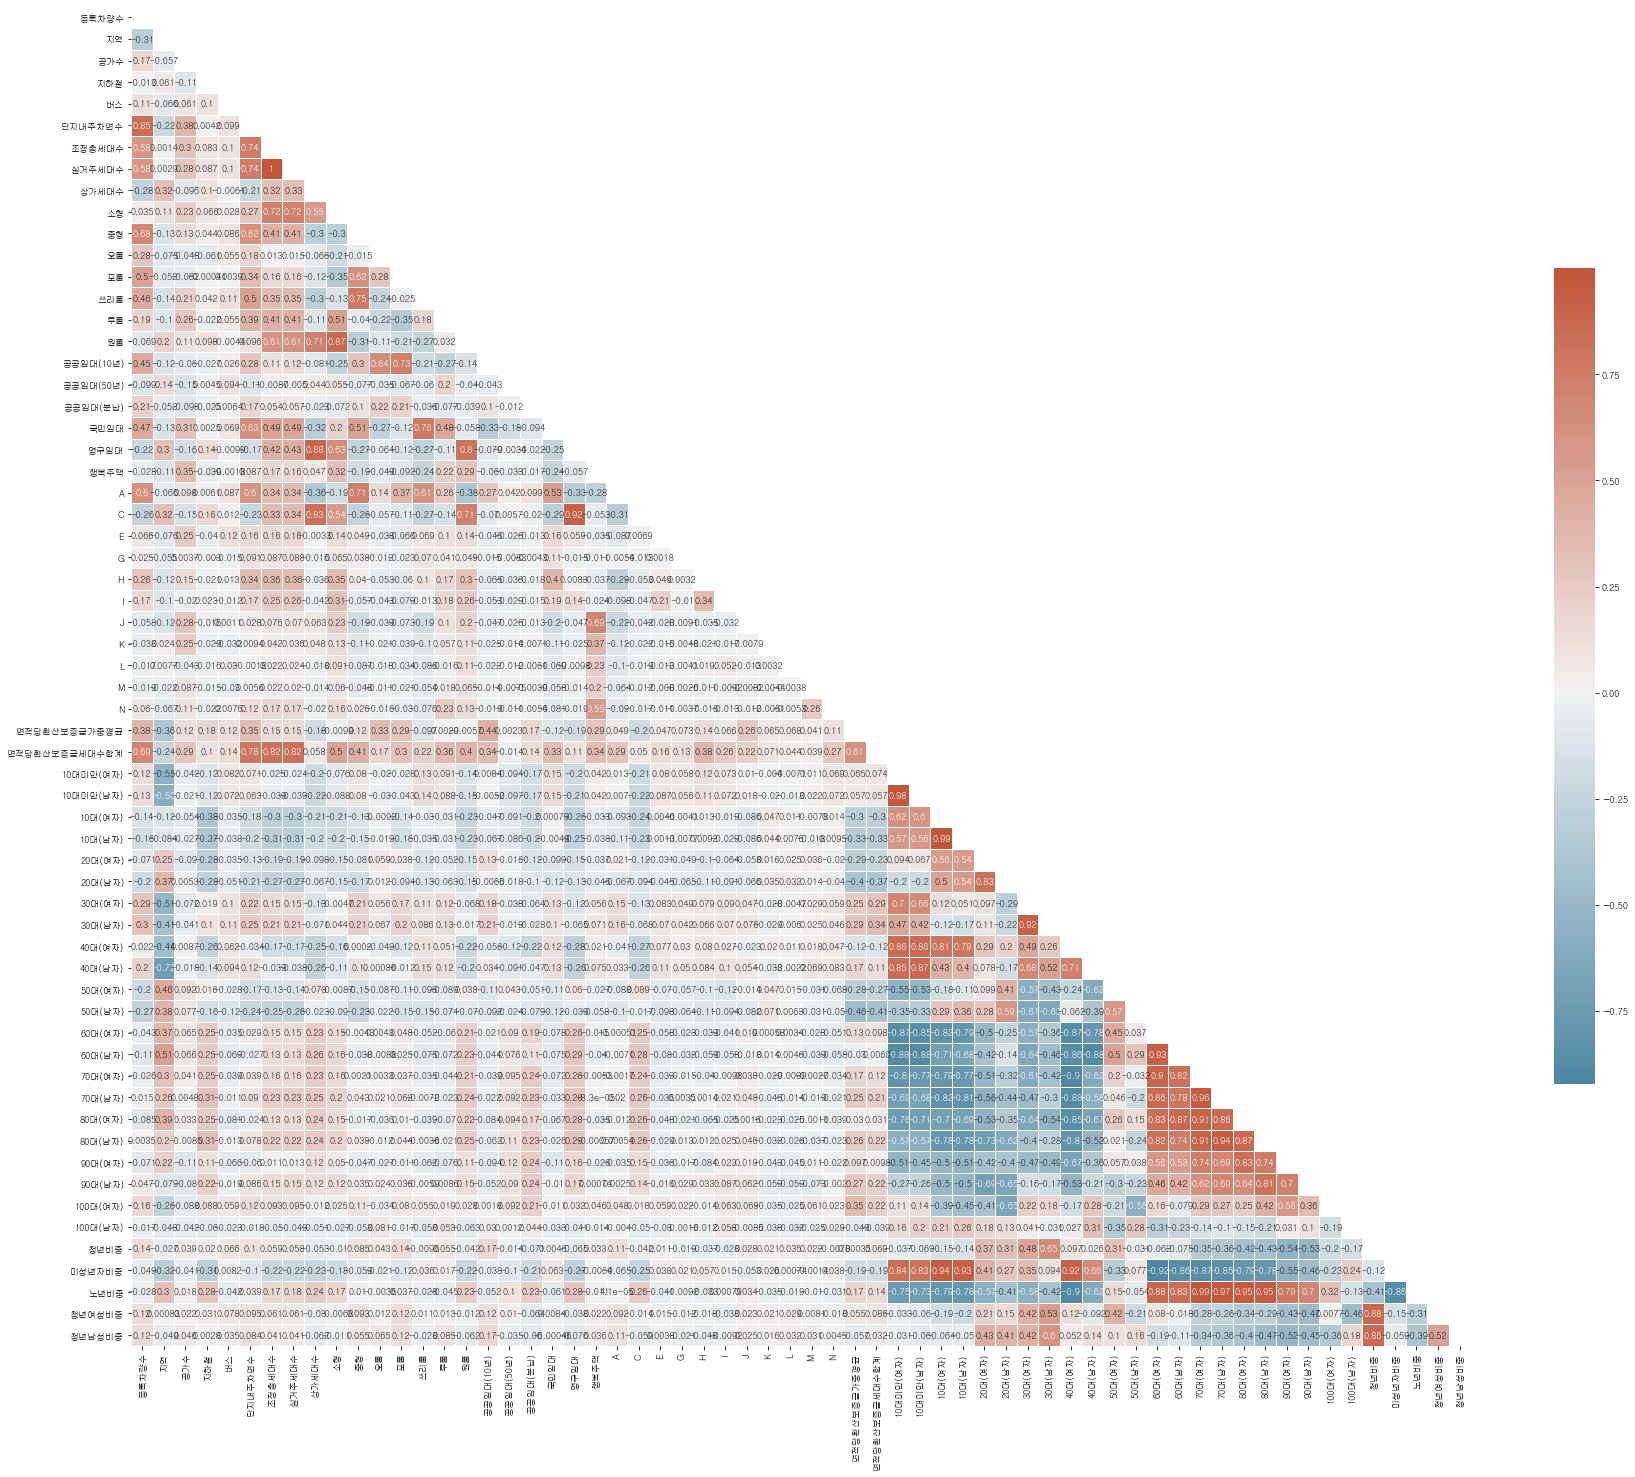

In [234]:
# Compute the correlation matrix
corr = train[ordered_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30, 30))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            annot=True)

plt.show()

In [235]:
# train.to_csv('preprocessed_train.csv', index=False)
# test.to_csv('preprocessed_test.csv', index=False)

train = pd.read_csv('preprocessed_train.csv')
test = pd.read_csv('preprocessed_test.csv')

# MODELING

In [236]:
set(train.columns).difference(test.columns)

{'B', 'F', 'O', '공공분양', '공공임대(5년)', '등록차량수', '장기전세'}

In [237]:
train.drop(['B', 'F', 'O', '공공분양','공공임대(5년)', '장기전세'], axis=1, inplace=True)

In [238]:
train.shape, test.shape

((423, 65), (150, 64))

## FEATURE SELECTION

In [253]:
x_train = train.loc[:, ~train.columns.isin(['단지코드', '등록차량수'])]
y_train = train['등록차량수']
x_test = test.loc[:, ~test.columns.isin(['단지코드'])]

In [254]:
x_train.shape, y_train.shape, x_test.shape

((423, 63), (423,), (150, 63))

In [255]:
# RFE는 Recursive Feature Elimination이라고 하여, 반복하여 변수를 제거해나가는 방식입니다.
from sklearn.feature_selection import RFE

In [298]:
model = RandomForestRegressor(random_state=42)
rfe = RFE(model,
          55) # feature의 개수를 지정할 수 있습니다. 3개로 해봅니다.
rfe_fit = rfe.fit(x_train, y_train)

In [299]:
print("Num Features: %s" % (rfe_fit.n_features_))
print("Selected Features: %s" % (rfe_fit.support_))
print("Feature Ranking: %s" % (rfe_fit.ranking_))

Num Features: 55
Selected Features: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
Feature Ranking: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [300]:
# rank를 확인할 수도 있습니다.
rfe_select = pd.DataFrame(rfe_fit.support_.tolist(), index=x_train.columns, columns=['true'])
rfe_select['rank'] = rfe_fit.ranking_.tolist()
rfe_select.sort_values('rank')

,true,rank
지역,True,1
100대(남자),True,1
청년비중,True,1
미성년자비중,True,1
노년비중,True,1
청년여성비중,True,1
청년남성비중,True,1
대형,True,1
소형,True,1
중형,True,1


In [262]:
model = LGBMRegressor(random_state=42)
rfe = RFE(model,
          10) # feature의 개수를 지정할 수 있습니다. 3개로 해봅니다.
rfe_fit = rfe.fit(x_train, y_train)

In [79]:
print("Num Features: %s" % (rfe_fit.n_features_))
print("Selected Features: %s" % (rfe_fit.support_))
print("Feature Ranking: %s" % (rfe_fit.ranking_))

Num Features: 10
Selected Features: [ True  True False False  True  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
  True  True False False False False False False  True False False False
 False False False False False False False False False False  True False
 False  True  True]
Feature Ranking: [ 1  1 26  6  1  1  8 17 11 29 34 40 31 24 27 36 12  4 18 16 21 52 23 22
  7 15 10 37 33 25 14 38 41 20 28 32  1  1 19 48 49  3 35 42  1 39 53 54
 30 47 46 50 51 43 44  2 45 13  1  9  5  1  1]


In [80]:
# rank를 확인할 수도 있습니다.
rfe_select = pd.DataFrame(rfe_fit.support_.tolist(), index=x_train.columns, columns=['true'])
rfe_select['rank'] = rfe_fit.ranking_.tolist()
rfe_select.sort_values('rank')

,true,rank
지역,True,1
투룸,True,1
A,True,1
중형,True,1
소형,True,1
면적당환산보증금가중평균,True,1
면적당환산보증금세대수합계,True,1
단지내주차면수,True,1
조정총세대수,True,1
공가수,True,1


## pycaret

In [105]:
params = {'train_size' : 0.8,
          #'categorical_features' : None,
          #'categorical_imputation' : ‘constant’,
          #'ordinal_features' : None,
          #'high_cardinality_features' : None,
          #'high_cardinality_method' : ‘frequency’,
          #'numeric_features' : None,
          #'numeric_imputation' : ‘mean’,
          #'date_features' : None,
          'ignore_features' : ['단지코드'],
          'normalize' : True,
          'normalize_method' : 'minmax',
          #'transformation' : False,
          #'transformation_method' : ‘yeo-johnson’,
          #'handle_unknown_categorical' : True,
          #'unknown_categorical_method' : ‘least_frequent’,
          #'pca' : False,
          #'pca_method' : ‘linear’,
          #'pca_components' : None,
          'ignore_low_variance' : True,
          'combine_rare_levels' : False,
          'rare_level_threshold' : 0.10,
          'bin_numeric_features' : None,
          #'remove_outliers' : False,
          #'outliers_threshold' : 0.05,
          'remove_multicollinearity' : True,
          'multicollinearity_threshold' : 0.9,
          'remove_perfect_collinearity' : True,
          #'create_clusters' : False,
          #'cluster_iter' : 20,
          #'polynomial_features' : False,
          #'polynomial_degree' : 2,
          #'trigonometry_features' : False,
          #'polynomial_threshold' : 0.1,
          #'group_features' : None,
          #'group_names' : None,
          'feature_selection' : True,
          'feature_selection_threshold' : 0.8,
          'feature_interaction' : False,
          'feature_ratio' : False,
          'interaction_threshold' : 0.01,
          #'transform_target' : False,
          #'transform_target_method' : ‘box-cox’,
          'data_split_shuffle' : True,
          'n_jobs' : -1,
          'html' : True,
          'session_id' : 42,
          'log_experiment' : False,
          'experiment_name' : None,
          'log_plots' : False,
          'log_profile' : False,
          'log_data' : False,
          'silent': False,
          'verbose' : True,
          'profile' : False}

In [106]:
exp_clf101 = setup(**params,
                   data = train, target = '등록차량수')

,Description,Value
0,session_id,42
1,Target,등록차량수
2,Original Data,"(423, 65)"
3,Missing Values,False
4,Numeric Features,60
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(338, 49)"


In [107]:
best_model = compare_models(sort = 'mse', exclude=['svm','ridge'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,112.1319,29444.1170,167.2502,0.7678,0.4123,0.3411,0.0050
lr,Linear Regression,118.5889,30630.0824,171.0502,0.7611,0.4663,0.3457,0.5020
lasso,Lasso Regression,117.6353,31221.5666,172.4323,0.7609,0.3785,0.3310,0.3950
br,Bayesian Ridge,119.6719,32218.0034,176.0779,0.7497,0.4306,0.3624,0.2700
llar,Lasso Least Angle Regression,115.3458,32721.6018,176.4525,0.7528,0.3673,0.3315,0.4980
par,Passive Aggressive Regressor,117.6630,34060.5017,181.2288,0.7359,0.3823,0.3413,0.0040
omp,Orthogonal Matching Pursuit,121.5809,34207.2598,179.9216,0.7399,0.3888,0.3399,0.4010
et,Extra Trees Regressor,119.7805,37701.8716,189.9259,0.7150,0.3275,0.2801,0.0290
catboost,CatBoost Regressor,119.9203,37793.7180,190.1396,0.7207,0.3569,0.3151,0.4370
rf,Random Forest Regressor,122.1286,38286.9843,191.2846,0.7169,0.3418,0.2963,0.0320


In [109]:
params = {'train_size' : 0.8,
          #'categorical_features' : None,
          #'categorical_imputation' : ‘constant’,
          #'ordinal_features' : None,
          #'high_cardinality_features' : None,
          #'high_cardinality_method' : ‘frequency’,
          #'numeric_features' : None,
          #'numeric_imputation' : ‘mean’,
          #'date_features' : None,
          'ignore_features' : ['단지코드'],
          'normalize' : False,
          #'normalize_method' : 'minmax',
          #'transformation' : False,
          #'transformation_method' : ‘yeo-johnson’,
          #'handle_unknown_categorical' : True,
          #'unknown_categorical_method' : ‘least_frequent’,
          #'pca' : False,
          #'pca_method' : ‘linear’,
          #'pca_components' : None,
          #'ignore_low_variance' : True,
          #'combine_rare_levels' : False,
          #'rare_level_threshold' : 0.10,
          #'bin_numeric_features' : None,
          #'remove_outliers' : False,
          #'outliers_threshold' : 0.05,
          #'remove_multicollinearity' : True,
          #'multicollinearity_threshold' : 0.9,
          #'remove_perfect_collinearity' : True,
          #'create_clusters' : False,
          #'cluster_iter' : 20,
          #'polynomial_features' : False,
          #'polynomial_degree' : 2,
          #'trigonometry_features' : False,
          #'polynomial_threshold' : 0.1,
          #'group_features' : None,
          #'group_names' : None,
          #'feature_selection' : True,
          #'feature_selection_threshold' : 0.8,
          #'feature_interaction' : False,
          #'feature_ratio' : False,
          #'interaction_threshold' : 0.01,
          #'transform_target' : False,
          #'transform_target_method' : ‘box-cox’,
          #'data_split_shuffle' : True,
          'n_jobs' : -1,
          #'html' : True,
          'session_id' : 42,
          #'log_experiment' : False,
          #'experiment_name' : None,
          #'log_plots' : False,
          #'log_profile' : False,
          #'log_data' : False,
          #'silent': False,
          #'verbose' : True,
          #'profile' : False
         }

In [110]:
exp_clf101 = setup(**params,
                   data = train, target = '등록차량수')

,Description,Value
0,session_id,42
1,Target,등록차량수
2,Original Data,"(423, 65)"
3,Missing Values,False
4,Numeric Features,60
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(338, 75)"


In [112]:
best_model = compare_models(sort = 'mse', exclude=['svm','ridge', 'lar'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,111.4129,31554.9841,173.4666,0.7609,0.3486,0.2986,0.0030
br,Bayesian Ridge,116.6860,32000.7158,175.3745,0.7547,0.3446,0.3010,0.0040
llar,Lasso Least Angle Regression,111.2612,32184.9693,174.7454,0.7574,0.3599,0.3181,0.0030
en,Elastic Net,119.2429,32562.7651,176.9526,0.7491,0.3627,0.3054,0.0040
lr,Linear Regression,118.4875,32754.5429,177.9436,0.7512,0.3522,0.3143,0.0030
lasso,Lasso Regression,120.3543,33070.7975,178.5301,0.7424,0.3822,0.3296,0.0040
et,Extra Trees Regressor,121.3759,37779.2865,189.9568,0.7223,0.3258,0.2778,0.0310
catboost,CatBoost Regressor,120.1731,37959.2065,190.8972,0.7167,0.3482,0.3025,0.4430
rf,Random Forest Regressor,121.4816,38150.0166,190.7237,0.7225,0.3404,0.2938,0.0340
gbr,Gradient Boosting Regressor,127.0730,40146.3133,196.6152,0.7068,0.3562,0.3094,0.0160


In [165]:
params = {'train_size' : 0.8,
          #'categorical_features' : None,
          #'categorical_imputation' : ‘constant’,
          #'ordinal_features' : None,
          #'high_cardinality_features' : None,
          #'high_cardinality_method' : ‘frequency’,
          'numeric_features' : ['G', 'M'],
          #'numeric_imputation' : ‘mean’,
          #'date_features' : None,
          'ignore_features' : ['단지코드'],
          'normalize' : False,
          #'normalize_method' : 'minmax',
          #'transformation' : False,
          #'transformation_method' : ‘yeo-johnson’,
          #'handle_unknown_categorical' : True,
          #'unknown_categorical_method' : ‘least_frequent’,
          #'pca' : False,
          #'pca_method' : ‘linear’,
          #'pca_components' : None,
          #'ignore_low_variance' : True,
          #'combine_rare_levels' : False,
          #'rare_level_threshold' : 0.10,
          #'bin_numeric_features' : None,
          #'remove_outliers' : False,
          #'outliers_threshold' : 0.05,
          #'remove_multicollinearity' : True,
          #'multicollinearity_threshold' : 0.9,
          #'remove_perfect_collinearity' : True,
          #'create_clusters' : False,
          #'cluster_iter' : 20,
          #'polynomial_features' : False,
          #'polynomial_degree' : 2,
          #'trigonometry_features' : False,
          #'polynomial_threshold' : 0.1,
          #'group_features' : None,
          #'group_names' : None,
          'feature_selection' : True,
          'feature_selection_threshold' : 0.8,
          #'feature_interaction' : False,
          #'feature_ratio' : False,
          #'interaction_threshold' : 0.01,
          #'transform_target' : False,
          #'transform_target_method' : ‘box-cox’,
          #'data_split_shuffle' : True,
          'n_jobs' : -1,
          #'html' : True,
          'session_id' : 42,
          #'log_experiment' : False,
          #'experiment_name' : None,
          #'log_plots' : False,
          #'log_profile' : False,
          #'log_data' : False,
          #'silent': False,
          #'verbose' : True,
          #'profile' : False
         }

In [166]:
exp_clf101 = setup(**params, data = train, target = '등록차량수')

,Description,Value
0,session_id,42
1,Target,등록차량수
2,Original Data,"(423, 65)"
3,Missing Values,False
4,Numeric Features,62
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(338, 75)"


In [167]:
best_model = compare_models(sort = 'mse', exclude=['svm','ridge', 'lar'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,111.4129,31554.9840,173.4666,0.7609,0.3486,0.2986,0.0030
br,Bayesian Ridge,116.5849,31933.3312,175.1990,0.7550,0.3477,0.3027,0.0030
lr,Linear Regression,117.6767,31986.5674,175.8359,0.7547,0.3482,0.2784,0.5020
llar,Lasso Least Angle Regression,111.2612,32184.9692,174.7454,0.7574,0.3599,0.3181,0.0030
en,Elastic Net,119.1540,32471.1042,176.8324,0.7487,0.3655,0.3029,0.2740
lasso,Lasso Regression,120.3785,33025.1216,178.4130,0.7418,0.4061,0.3273,0.4000
et,Extra Trees Regressor,120.4118,38047.9875,189.9287,0.7191,0.3317,0.2836,0.0340
rf,Random Forest Regressor,121.6654,38471.6339,191.4178,0.7200,0.3423,0.2950,0.0350
catboost,CatBoost Regressor,119.2658,38625.4649,192.8500,0.7142,0.3439,0.2931,0.4590
gbr,Gradient Boosting Regressor,126.5760,39270.2651,195.1116,0.7109,0.3552,0.3089,0.0160


## TRAINING

In [116]:
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import LassoLars

### OMP: 120.2174

In [118]:
x_train = x_train.drop(['M', 'L'], axis=1)
x_test = x_test.drop(['M', 'L'], axis=1)

In [119]:
x_train = x_train.drop(['K'], axis=1)
x_test = x_test.drop(['K'], axis=1)

In [120]:
x_train.shape, y_train.shape, x_test.shape

((423, 60), (423,), (150, 60))

In [121]:
omp = OrthogonalMatchingPursuit()

In [122]:
omp.fit(x_train, y_train)

OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=None,
                          normalize=True, precompute='auto', tol=None)

In [124]:
omp_pred = omp.predict(x_test)

In [126]:
sub.num = omp_pred

In [127]:
sub.to_csv('submission/parking_210622_withOMPtest.csv', index=False)

### LLAR: 116.3214

In [266]:
x_train = x_train.drop(['M', 'L'], axis=1)
x_test = x_test.drop(['M', 'L'], axis=1)

In [267]:
x_train = x_train.drop(['K'], axis=1)
x_test = x_test.drop(['K'], axis=1)

In [268]:
x_train = x_train.drop(['N'], axis=1)
x_test = x_test.drop(['N'], axis=1)

In [270]:
x_train = x_train.drop(['공공임대(분납)'], axis=1)
x_test = x_test.drop(['공공임대(분납)'], axis=1)

In [281]:
x_train = x_train.drop(['C'], axis=1)
x_test = x_test.drop(['C'], axis=1)

In [291]:
x_train = x_train.drop(['E'], axis=1)
x_test = x_test.drop(['E'], axis=1)

In [301]:
x_train = x_train.drop(['공공임대(50년)'], axis=1)
x_test = x_test.drop(['공공임대(50년)'], axis=1)

In [302]:
x_train.shape, y_train.shape, x_test.shape

((423, 55), (423,), (150, 55))

In [303]:
llar = LassoLars(alpha=0.01)

In [304]:
llar.fit(x_train, y_train)

LassoLars(alpha=0.01, copy_X=True, eps=2.220446049250313e-16,
          fit_intercept=True, fit_path=True, jitter=None, max_iter=500,
          normalize=True, positive=False, precompute='auto', random_state=None,
          verbose=False)

In [305]:
llar_pred = llar.predict(x_test)

In [306]:
sub.num = llar_pred

In [307]:
sub.to_csv('submission/parking_210624_withLLAR-MLKN분납CE50년.csv', index=False)

### RF

In [81]:
x_train = x_train.drop(['M', 'L'], axis=1)
x_test = x_test.drop(['M', 'L'], axis=1)

In [82]:
x_train = x_train.drop(['K'], axis=1)
x_test = x_test.drop(['K'], axis=1)

In [145]:
x_train.shape, y_train.shape, x_test.shape

((423, 60), (423,), (150, 60))

In [146]:
rf = RandomForestRegressor(random_state=42, oob_score=True, criterion='mse', n_estimators=200)
rf.fit(x_train, y_train)
pred = rf.predict(x_test)

In [147]:
rf.oob_score_

0.7735456014066945

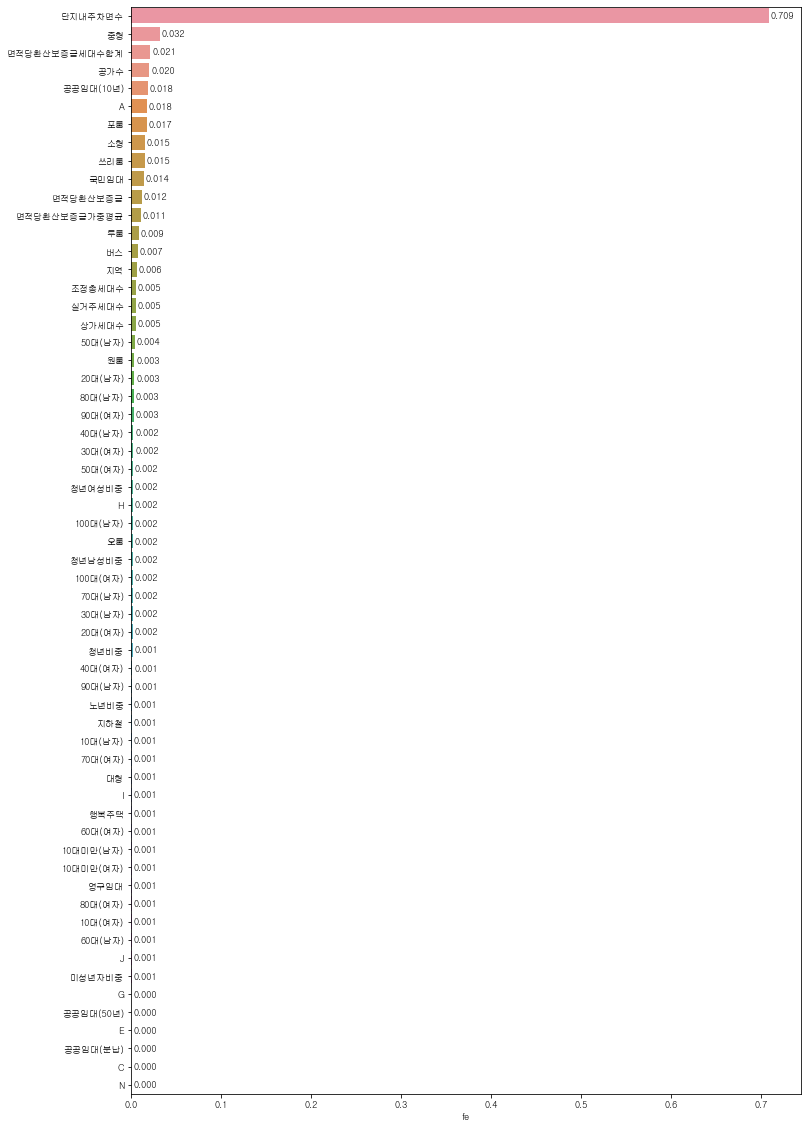

In [148]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "9"

fe_avg = pd.DataFrame(rf.feature_importances_,
                      index=x_train.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(12, 20))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(0.015+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.3f}'.format(width),
             ha='center', va='center')

plt.show()

In [149]:
sub.num = pred

In [150]:
sub

,code,num
0,C1072,802.115
1,C1128,1231.655
2,C1456,511.035
3,C1840,489.065
4,C1332,1095.030
...,...,...
145,C2456,241.945
146,C1266,482.170
147,C2152,50.065
148,C1267,328.550


In [151]:
sub.to_csv('submission/parking_210623_541937-MNK.csv', index=False)

### LGBM: 123.9439

In [138]:
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor

In [139]:
N_FOLD = 5

In [140]:
kfold = KFold(n_splits=N_FOLD, shuffle=True, random_state=42)
folds = []
for train_idx, valid_idx in kfold.split(x_train, y_train):
    folds.append((train_idx, valid_idx))

preds = []
fe = []
models = {}
for fold in range(5):
    train_idx, valid_idx = folds[fold]
    X_tra = x_train.iloc[train_idx, :]
    y_tra = y_train.iloc[train_idx]
    X_val = x_train.iloc[valid_idx, :]
    y_val = y_train.iloc[valid_idx]

    model=LGBMRegressor(learning_rate=0.027, random_state=42, n_estimators=10000)
    model.fit(X_tra, y_tra, eval_set=[(X_tra, y_tra), (X_val, y_val)],
              eval_metric='mse',
              early_stopping_rounds=30, verbose=100)
    models[fold]=model

for k in range(N_FOLD):
    preds.append(models[k].predict(x_test))
    fe.append(models[k].feature_importances_)

Training until validation scores don't improve for 30 rounds
[100]	training's l2: 21125.7	valid_1's l2: 37794.9
Early stopping, best iteration is:
[155]	training's l2: 14965.4	valid_1's l2: 35869.7
Training until validation scores don't improve for 30 rounds
[100]	training's l2: 21629.4	valid_1's l2: 35015.7
[200]	training's l2: 13291.6	valid_1's l2: 32444.4
Early stopping, best iteration is:
[237]	training's l2: 11475.4	valid_1's l2: 32233.4
Training until validation scores don't improve for 30 rounds
[100]	training's l2: 20838.5	valid_1's l2: 36569.4
Early stopping, best iteration is:
[148]	training's l2: 15148.7	valid_1's l2: 33351.9
Training until validation scores don't improve for 30 rounds
[100]	training's l2: 16400	valid_1's l2: 52097.8
Early stopping, best iteration is:
[88]	training's l2: 18462.1	valid_1's l2: 51803
Training until validation scores don't improve for 30 rounds
[100]	training's l2: 19955.9	valid_1's l2: 35539.2
Early stopping, best iteration is:
[124]	training'

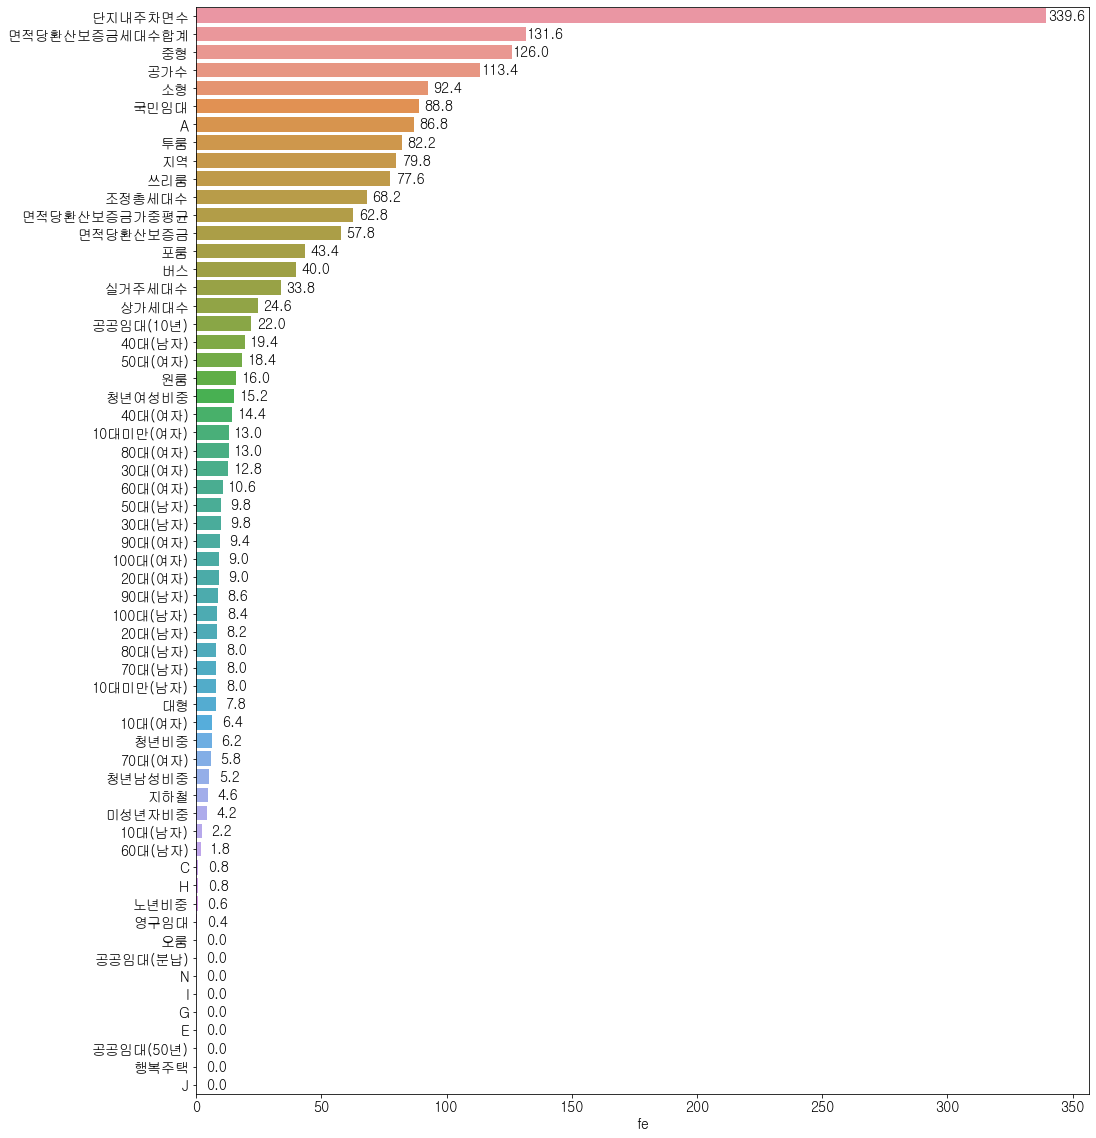

In [141]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "14"

fe_avg = pd.DataFrame(np.array(fe).mean(axis=0),
                      index=x_train.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(16, 20))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(8+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.1f}'.format(width),
             ha='center', va='center')

plt.show()

In [142]:
sub.num = np.array(preds).mean(axis=0)

In [143]:
sub

,code,num
0,C1072,843.084934
1,C1128,1381.933414
2,C1456,512.029400
3,C1840,477.055579
4,C1332,1238.193951
...,...,...
145,C2456,249.174859
146,C1266,477.367431
147,C2152,96.746830
148,C1267,283.734455


In [144]:
sub.to_csv('submission/parking_210622_kfoldlgbmtest.csv', index=False)